In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os, glob
os.environ['CUDA_VISIBLE_DEVICES'] = '0' # GPU
import tensorflow.python as tf

import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
from scipy import signal, ndimage
from scipy.io import loadmat, savemat
from skimage import data, img_as_float, exposure
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle

In [2]:
from func_processing import img_affine, img_hflip, load, get_y_as_heatmap, get_avg_xy
from sklearn.model_selection import train_test_split

FTRAIN = './data/facial-keypoints-detection/training.csv'

In [3]:
# load data
X, Y = load(FTRAIN)
X = X.reshape(-1,96,96)
# split into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)
X_train = np.expand_dims(X_train, axis=3)
X_test = np.expand_dims(X_test, axis=3)

In [4]:
# training data augmentation
np.random.seed(0)
dz = np.random.randint(-5,5,(X_train.shape[0],2))
X_train0 = []
Y_train0 = []
for i, x in enumerate(X_train):
    xt, yt = img_affine(np.squeeze(x), Y_train[i], dz[i,0], dz[i,1], 96, 96)
    X_train0.append(xt)
    Y_train0.append(yt)
    xf, yf = img_hflip(np.squeeze(x), Y_train[i])
    X_train0.append(xf)
    Y_train0.append(yf)
X_train0 = np.array(X_train0)
Y_train0 = np.array(Y_train0)

X_train0 = np.expand_dims(X_train0, axis=3)

In [5]:
Y_train0.shape

(3852, 30)

In [6]:
from func_FCN import FCN

y_train0 = get_y_as_heatmap(Y_train0, 96, 96, 5)
X_train, X_valid, y_train, y_valid = train_test_split(X_train0, y_train0, test_size=0.2, random_state=43)

model = FCN(96, 96, 64)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
callbacks = [
EarlyStopping(patience=10, verbose=1),
ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
ModelCheckpoint('model-tgs-seg2.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

history = model.fit(X_train, y_train, batch_size=32, epochs=50, callbacks=callbacks, validation_data=(X_valid, y_valid))

Epoch 1/50
97/97 [==============================] - 11s 70ms/step - loss: 0.0067 - accuracy: 0.2121 - val_loss: 0.0050 - val_accuracy: 0.3281

Epoch 00001: val_loss improved from inf to 0.00504, saving model to model-tgs-seg2.h5
Epoch 2/50
97/97 [==============================] - 7s 71ms/step - loss: 0.0047 - accuracy: 0.3353 - val_loss: 0.0044 - val_accuracy: 0.3574

Epoch 00002: val_loss improved from 0.00504 to 0.00440, saving model to model-tgs-seg2.h5
Epoch 3/50
97/97 [==============================] - 7s 70ms/step - loss: 0.0042 - accuracy: 0.3748 - val_loss: 0.0039 - val_accuracy: 0.3778

Epoch 00003: val_loss improved from 0.00440 to 0.00386, saving model to model-tgs-seg2.h5
Epoch 4/50
97/97 [==============================] - 7s 69ms/step - loss: 0.0034 - accuracy: 0.3658 - val_loss: 0.0029 - val_accuracy: 0.3744

Epoch 00004: val_loss improved from 0.00386 to 0.00293, saving model to model-tgs-seg2.h5
Epoch 5/50
97/97 [==============================] - 7s 69ms/step - loss: 0.

In [7]:
plt.plot(history.history['loss'], label='traning loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.yscale('log')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('loss')
# plt.savefig('./model/hist_fcn.png')
plt.close()

In [8]:
model.save('./model/fcn')

INFO:tensorflow:Assets written to: ./model/fcn\assets


Reload trained data and test

In [9]:
model = tf.keras.models.load_model('./model/fcn')

In [11]:
# test and convert predict heatmap to coordinate of key points
test_pred = model.predict(X_test)
loc_pred = []
for pred in test_pred:
    y_pred = np.zeros(30)
    for j in range(15):
        msk = np.squeeze(pred[:,:,j])
        yx, prob = get_avg_xy(msk, 25)
        y_pred[2*j] = yx[1] / 96
        y_pred[2*j+1] = yx[0] / 96
    loc_pred.append(y_pred)

loc_pred = np.array(loc_pred) * 96
loc_label = np.array(Y_test) * 96

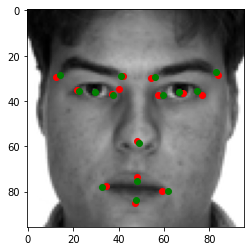

In [12]:
# display a sample testing results
img = np.squeeze(X_test[0])
predicted = loc_pred[0]
label = loc_label[0]


plt.imshow(img, cmap='gray')
for i in range(15):
    plt.scatter(predicted[2*i], predicted[2*i+1], c='r')
    plt.scatter(label[2*i], label[2*i+1], c='g')

plt.show()

In [13]:
# calculate average distance between predict and label points
distance = []
for i in range(15):
    distance.append(np.sqrt((loc_pred[:,2*i] - loc_label[:,2*i]) ** 2 + (loc_pred[:,2*i+1] - loc_label[:,2*i+1]) ** 2))
distance = np.array(distance)
avg_dist_per_loc = np.mean(distance, axis=1)
avg_dist = np.mean(avg_dist_per_loc)
print('average error distance among all 15 key points is %f\n'%(avg_dist))

average error distance among all 15 key points is 6.058904



In [14]:
avg_dist_per_loc

array([ 6.69964701,  6.44957369,  4.5376451 ,  9.38849428,  4.18825717,
        9.15337856,  4.11551069, 12.91546083,  4.21771784, 12.6971305 ,
        1.15540162,  6.41488219,  6.25782664,  1.20774105,  1.48489249])